## Trabalho Prático #2: Planejamento e navegação ##
#### Integrantes: ####
* Filipe Rodrigues Batista de Oliveira 
* Lucas Avelar 

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt

import sim

### Parte I - 

### Parte II - Campos Potenciais.

Primeiramente vamos definir algumas constantes

In [2]:
DIST_LIMITE_OBJ = 0.5
RAIO_INFLUENCIA_OBS = 2

Agora, implementamos as funções que vão calcular as forças de repulsão e de atração, sendo combinados posteriormente no código principal.

In [3]:
def calcular_forca_rep(q, obstaculos, k_rep = 10000):
    # Se não tem obstáculos.
    if obstaculos is None:
        return np.zeros((1,2))
    else:
        diff_pos = q - np.array(obstaculos)
        d = np.linalg.norm(diff_pos)

        forca_rep = (1/d**2)*((1/d)-(1/RAIO_INFLUENCIA_OBS))*(diff_pos/d)    
        
        return k_rep * forca_rep

In [4]:
def calcular_forca_attr(q, obj, k_attr=0.1):
    forca_attr = k_attr * (obj - q)
    
    return forca_attr

Para ler as informações vindas do sensor e a plotagem.

In [5]:
def readSensorData(clientId=-1, 
                    range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):

    # the first call should be non-blocking to avoid getting out-of-sync angle data
    returnCodeRanges, string_range_data = sim.simxGetStringSignal(clientId, range_data_signal_id, sim.simx_opmode_streaming)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    returnCodeAngles, string_angle_data = sim.simxGetStringSignal(clientId, angle_data_signal_id, sim.simx_opmode_blocking)

    # check the if both data were obtained correctly
    if returnCodeRanges == 0 and returnCodeAngles == 0:
        # unpack data from range and sensor messages
        raw_range_data = sim.simxUnpackFloats(string_range_data)
        raw_angle_data = sim.simxUnpackFloats(string_angle_data)

        return raw_range_data, raw_angle_data

    # return none in case were nothing was gotten from the simulator
    return None

def draw_laser_data(laser_data, max_sensor_range=5):
    
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(x, y, 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)
        
    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

Finalmente o código principal

/tmp/ipykernel_40234/4216603276.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6,6), dpi=100)


KeyboardInterrupt: 

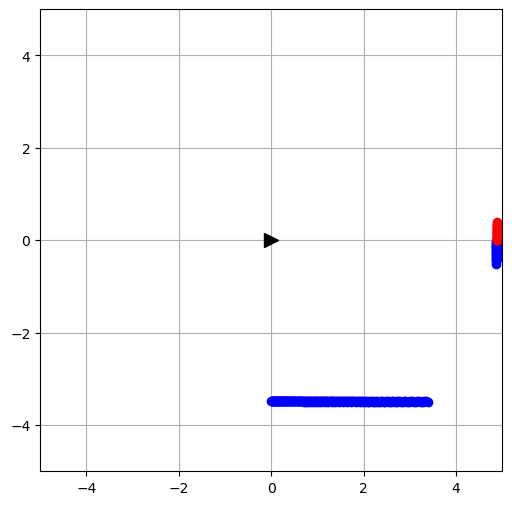

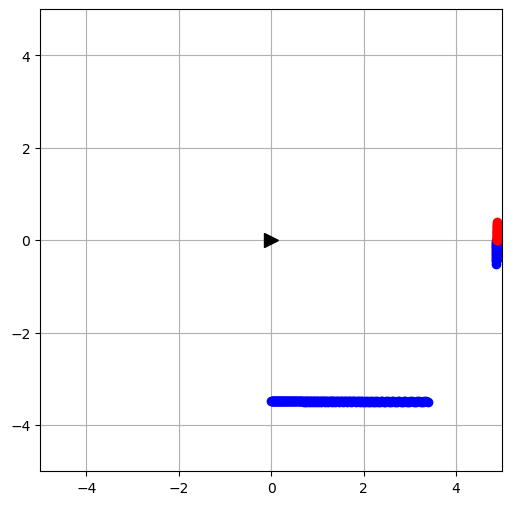

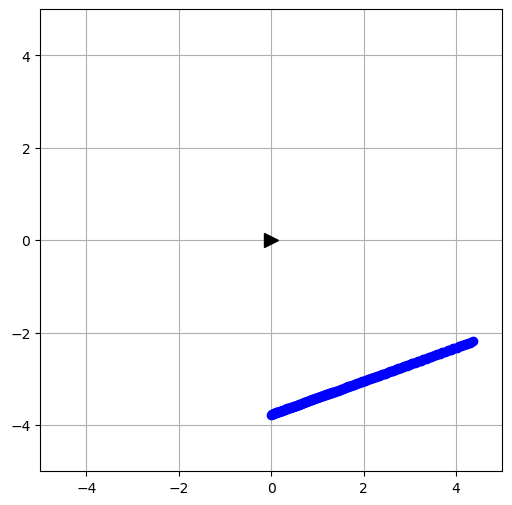

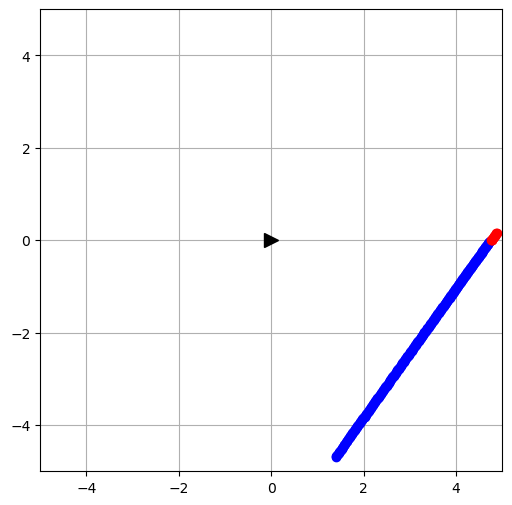

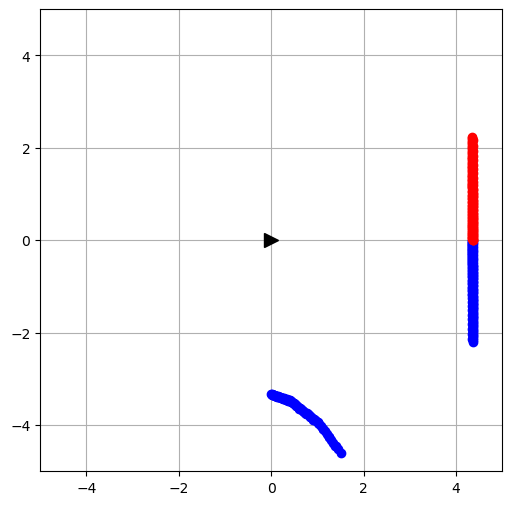

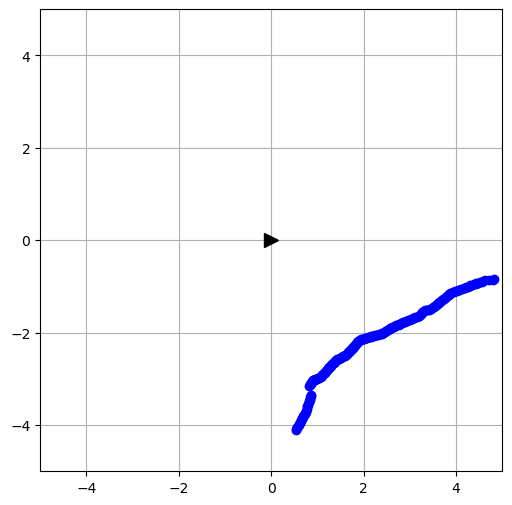

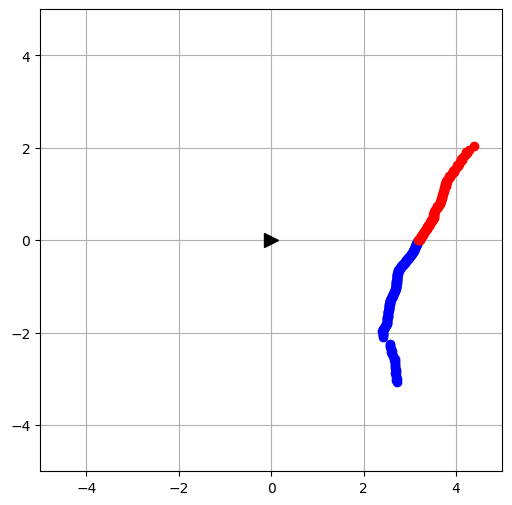

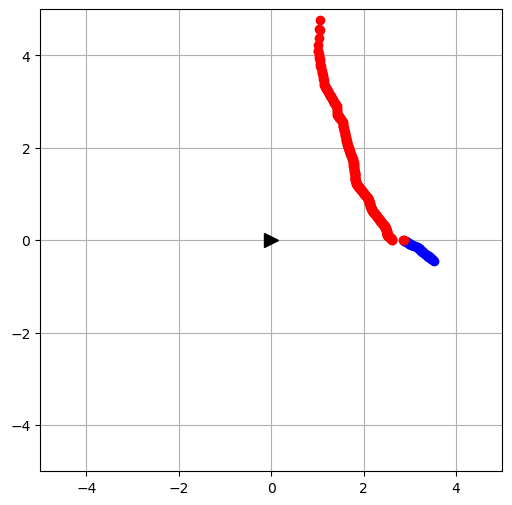

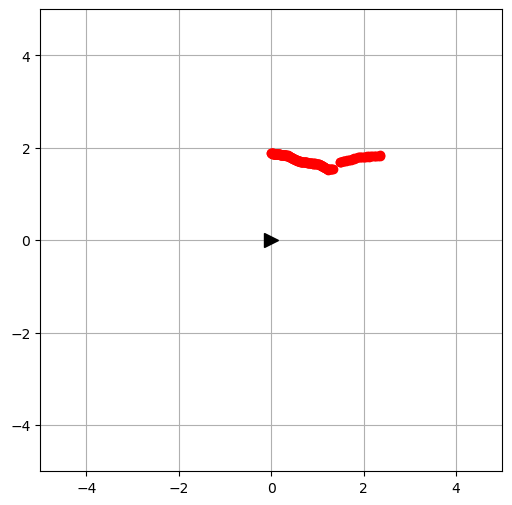

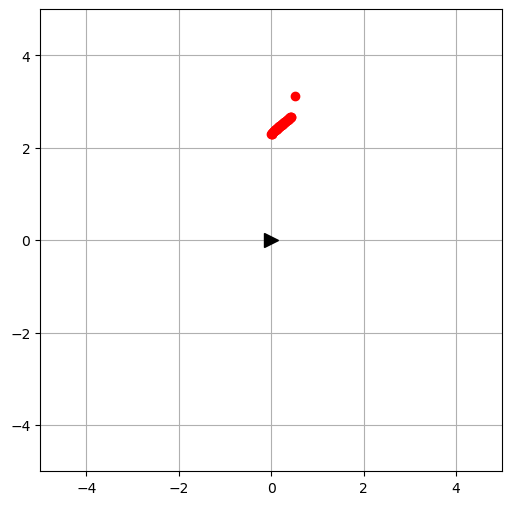

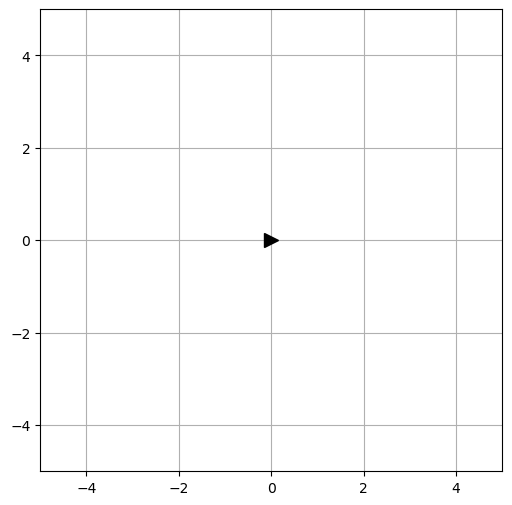

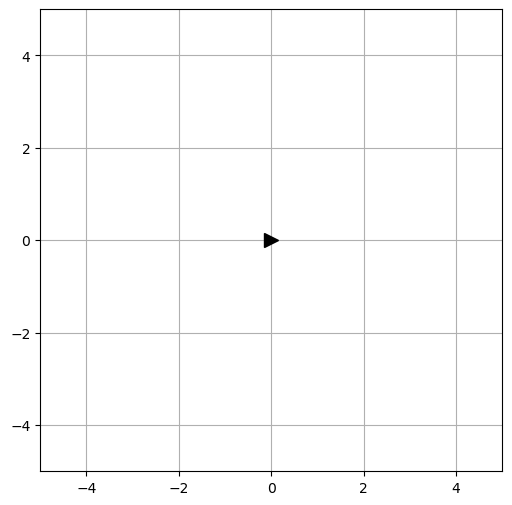

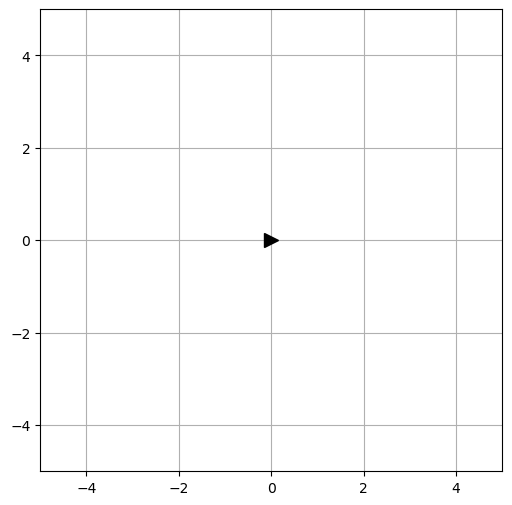

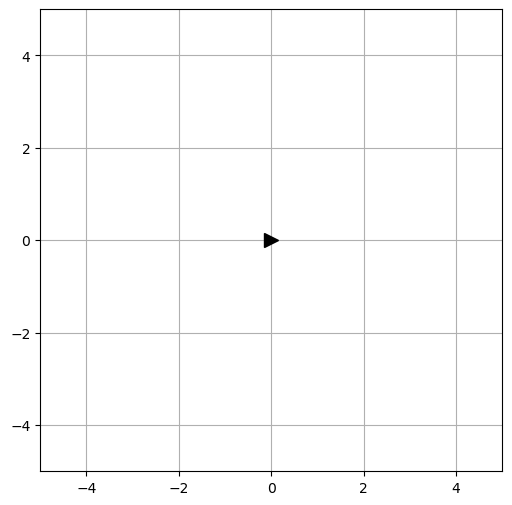

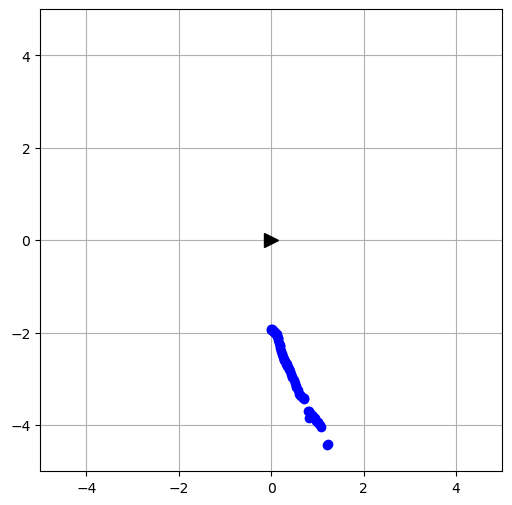

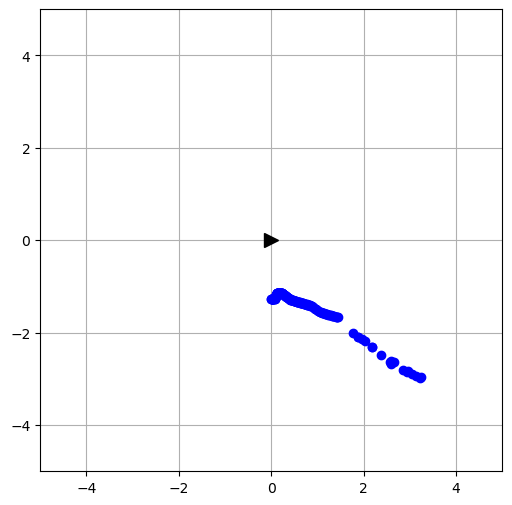

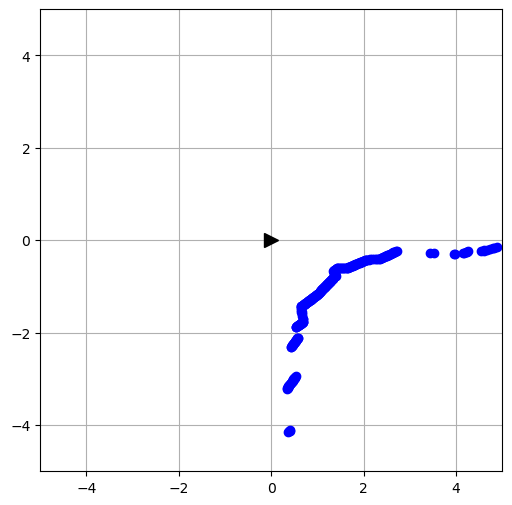

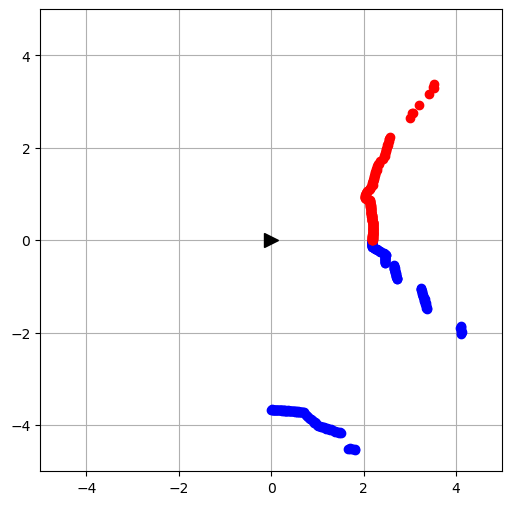

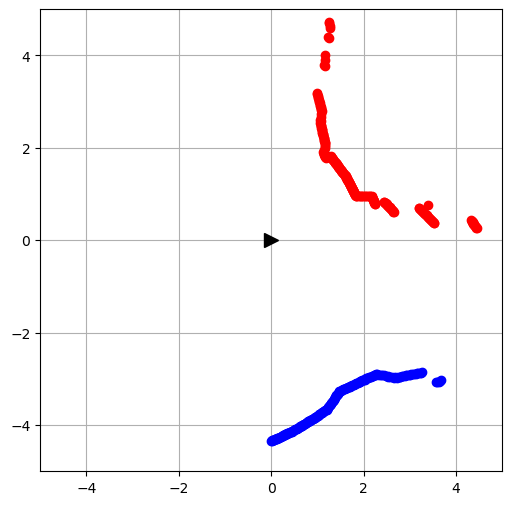

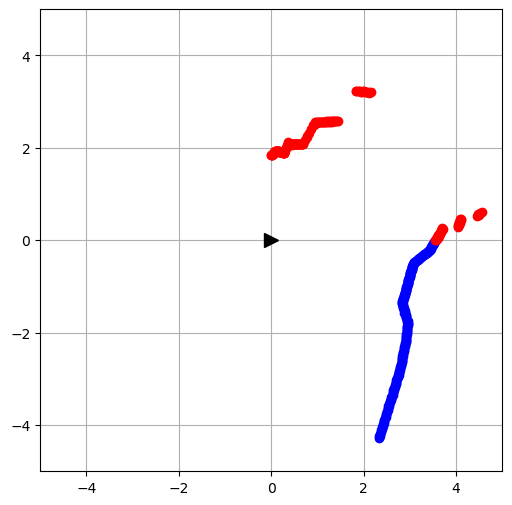

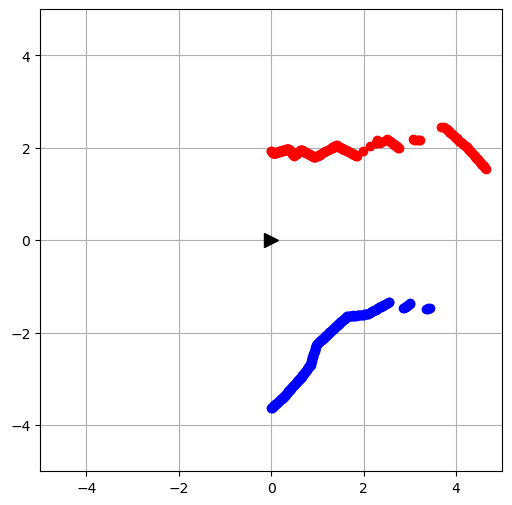

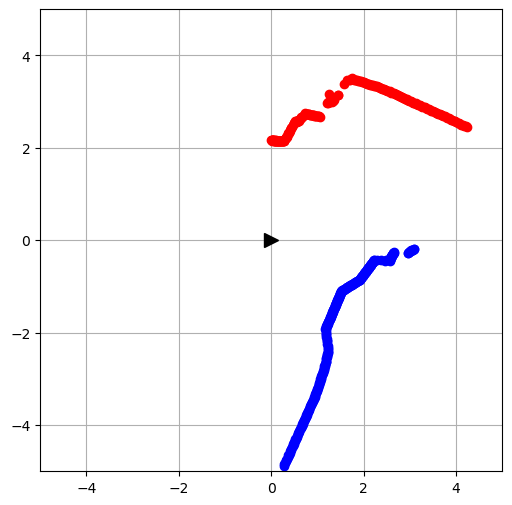

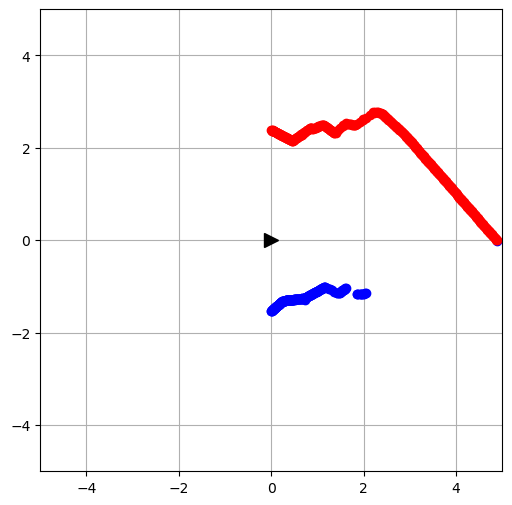

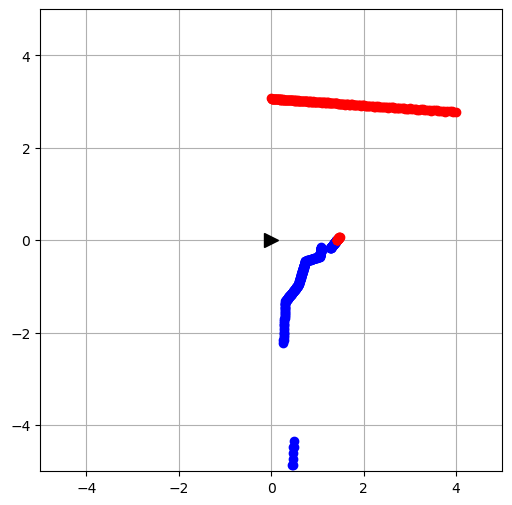

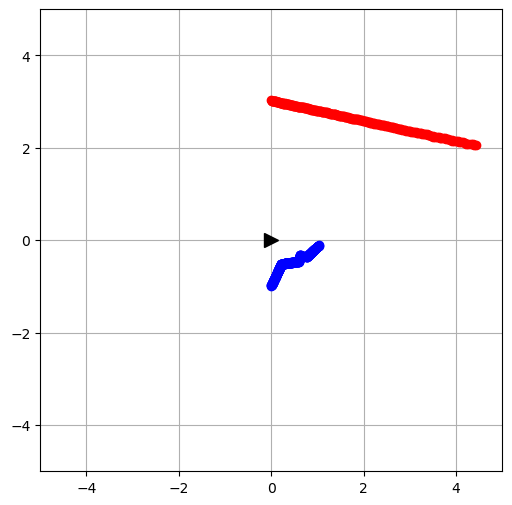

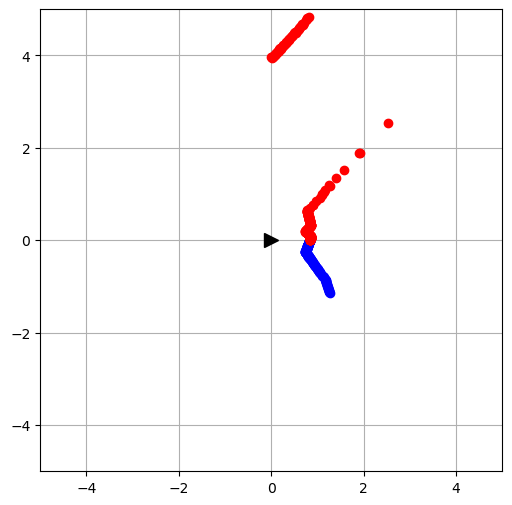

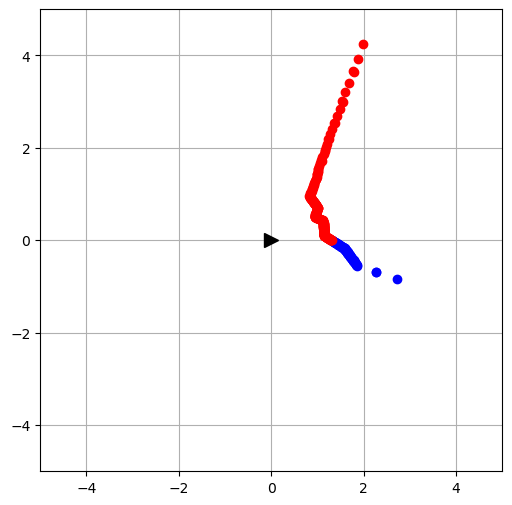

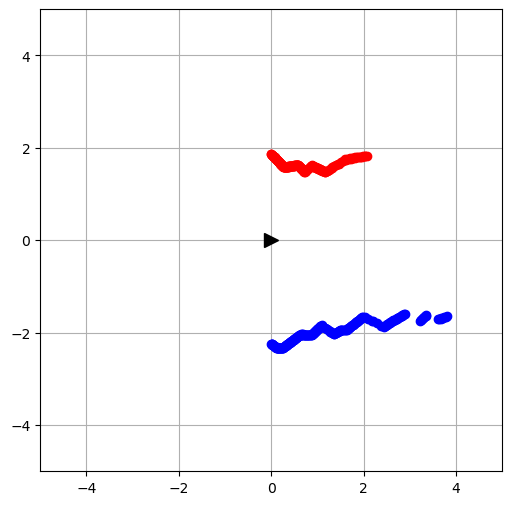

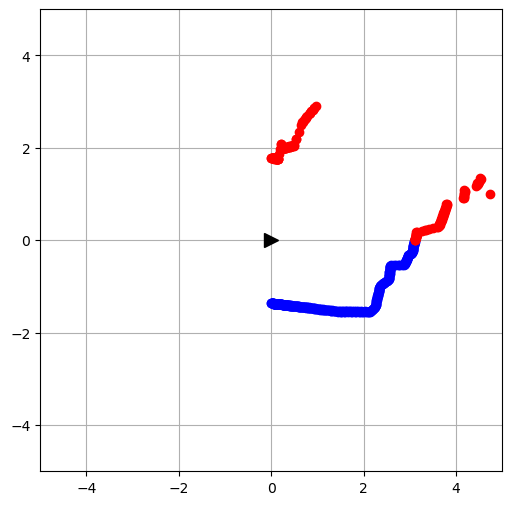

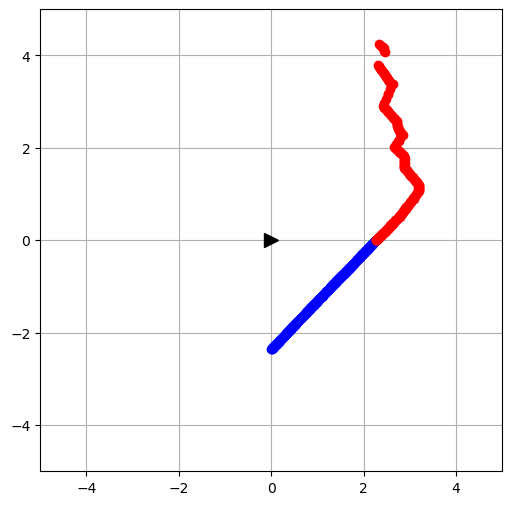

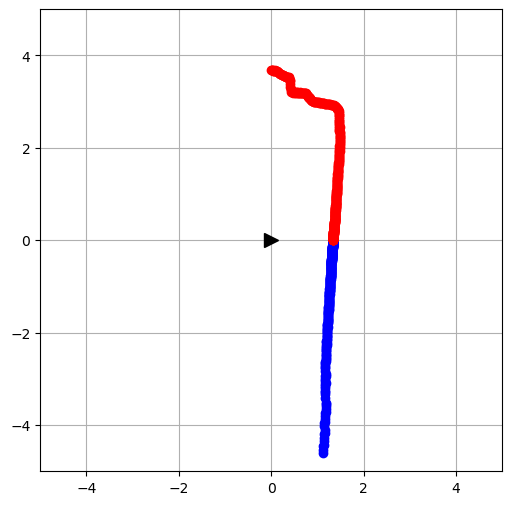

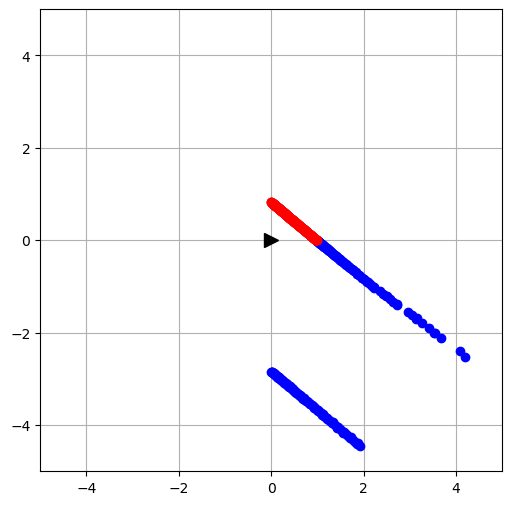

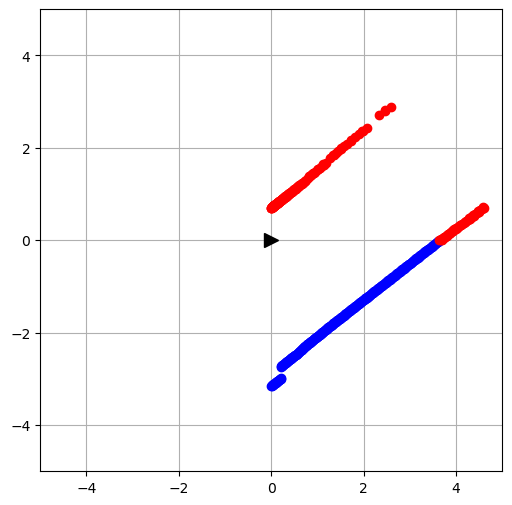

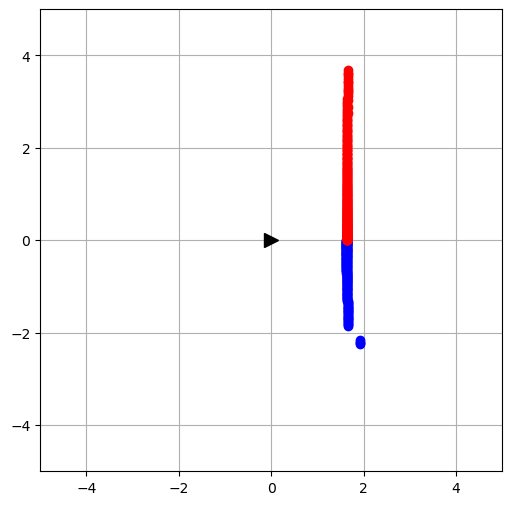

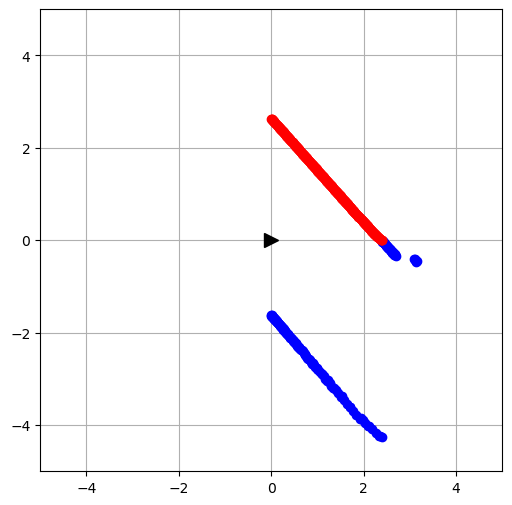

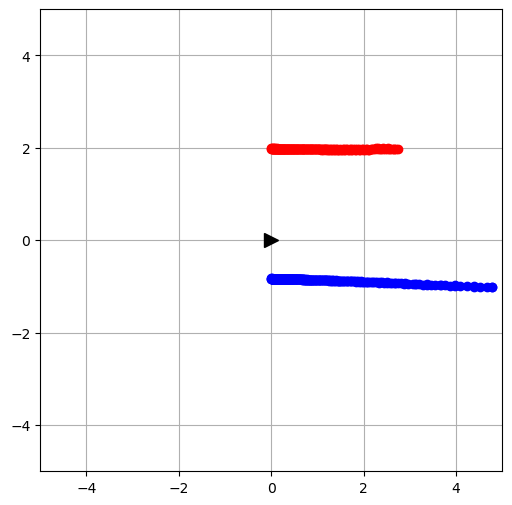

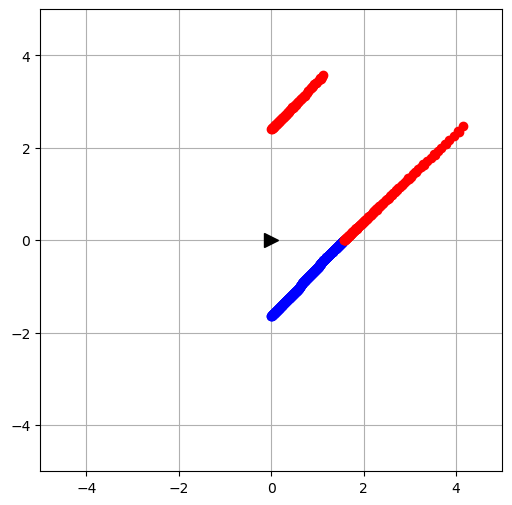

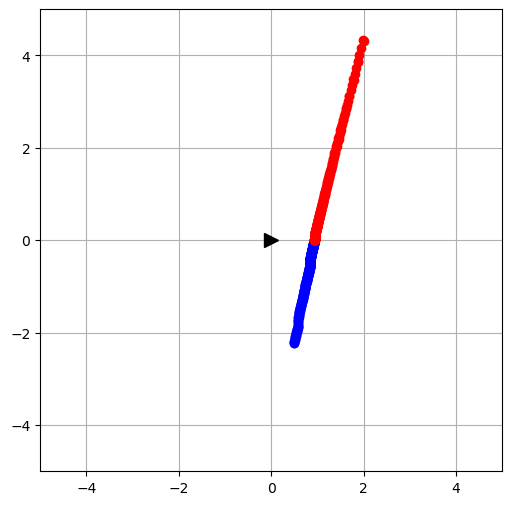

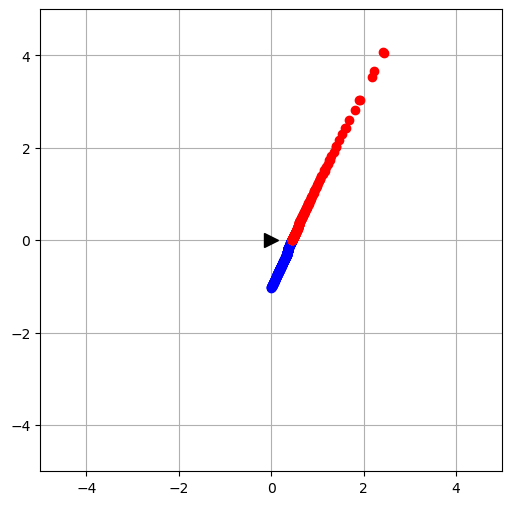

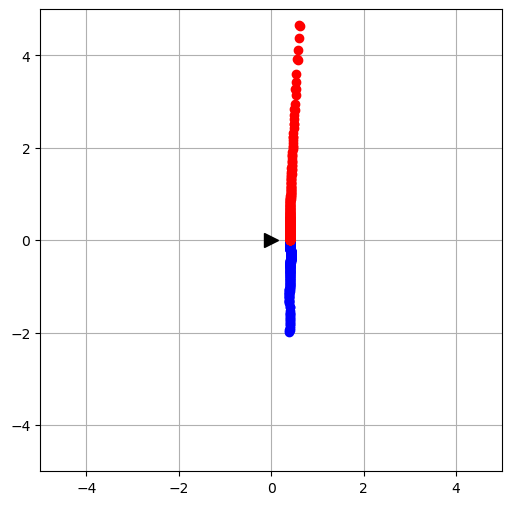

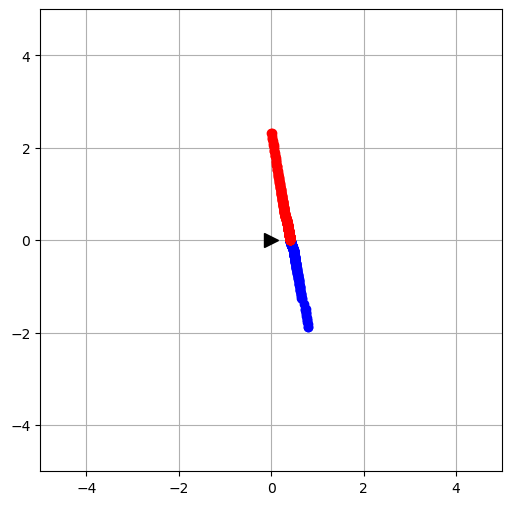

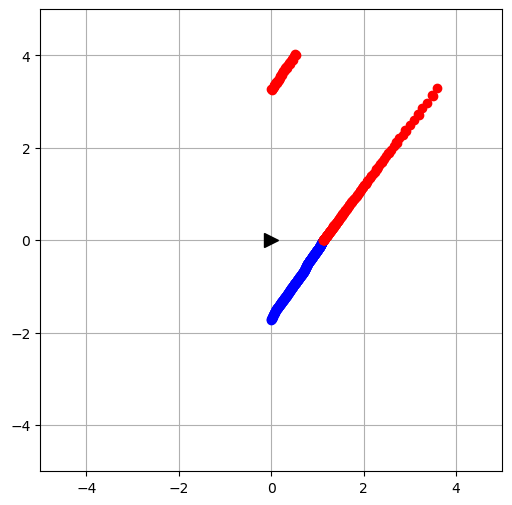

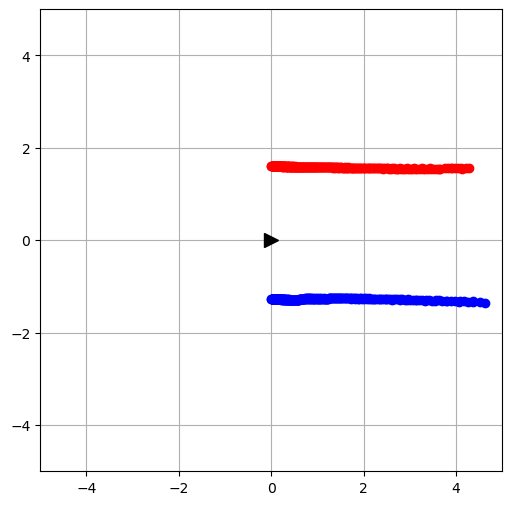

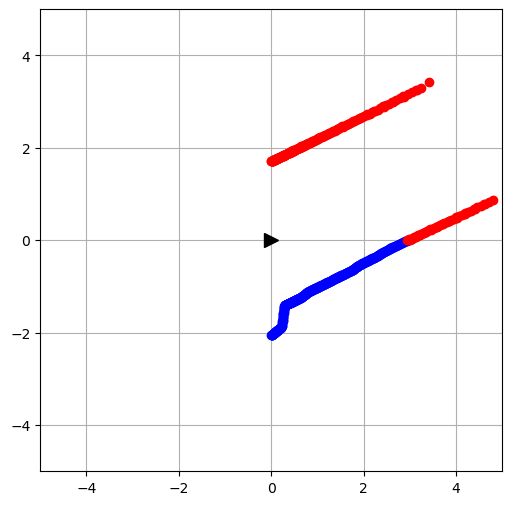

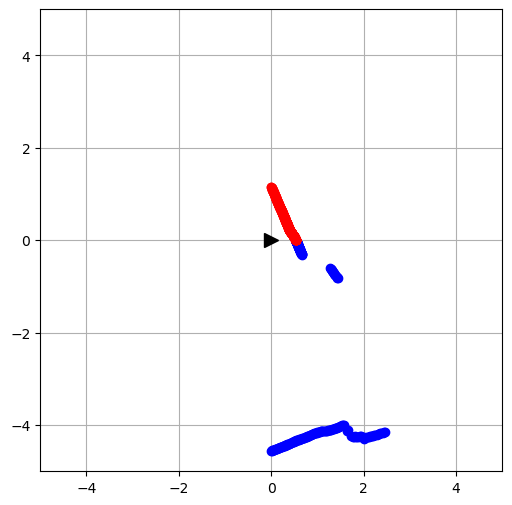

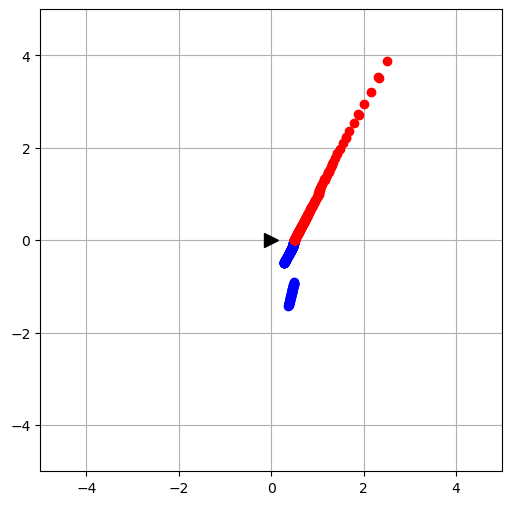

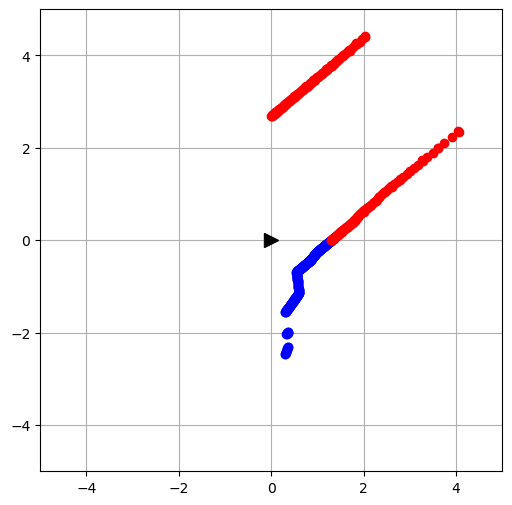

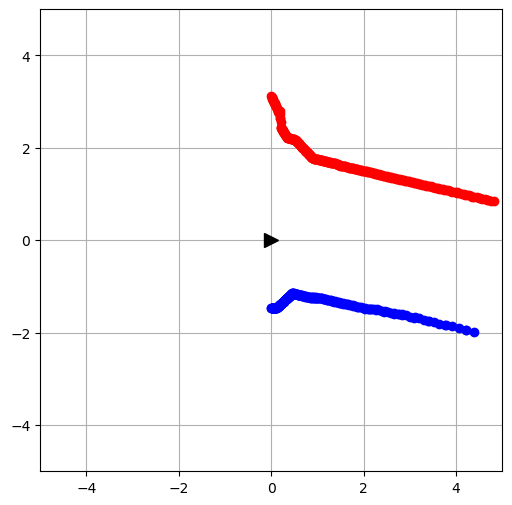

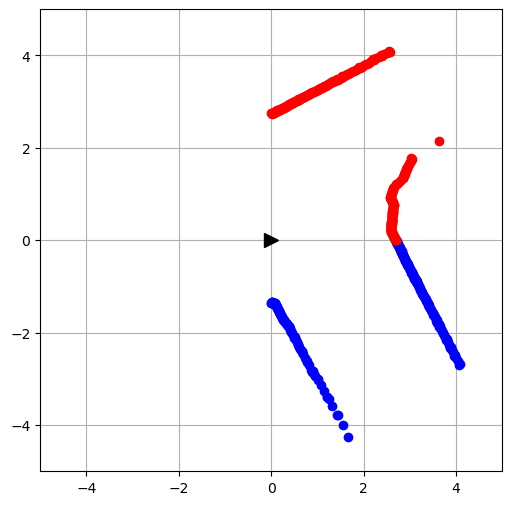

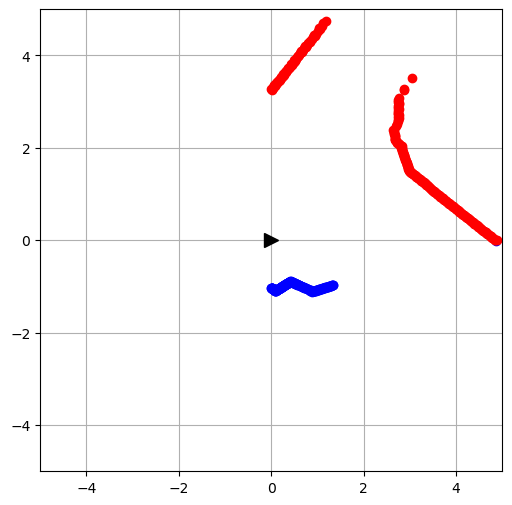

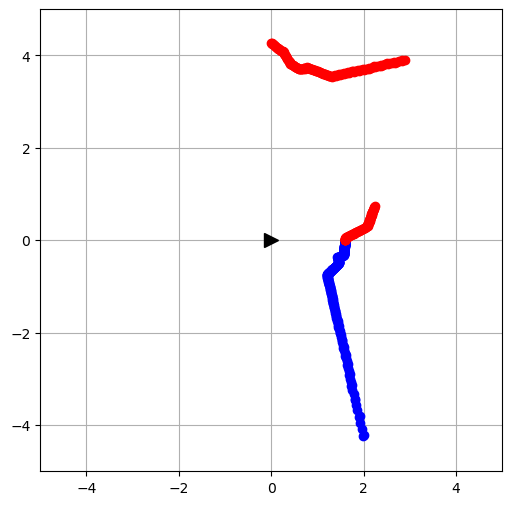

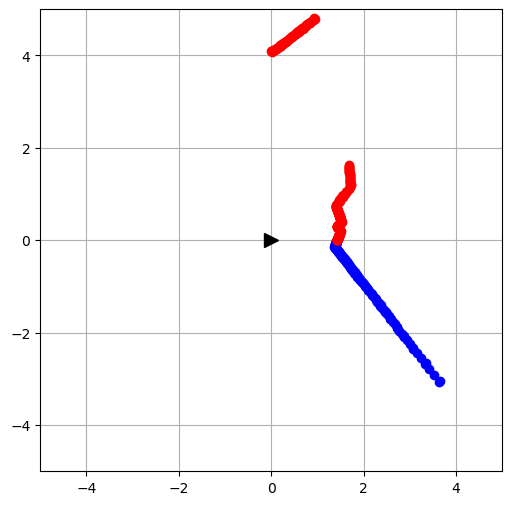

In [6]:
sim.simxFinish(-1)
id_cliente = sim.simxStart("127.0.0.1", 19999, True, True, 50000, 5)

if id_cliente != -1:
    # Dimensões do robô.
    L = 0.381
    r = 0.09751
    
    maxv = 0.5
    maxw = np.deg2rad(30)
    
    robo_nome = "Pioneer_p3dx"
    rv, robo = sim.simxGetObjectHandle(id_cliente, robo_nome, sim.simx_opmode_oneshot_wait)
    rv, roda_dir = sim.simxGetObjectHandle(id_cliente, robo_nome + "_rightMotor", sim.simx_opmode_oneshot_wait)
    rv, roda_esq = sim.simxGetObjectHandle(id_cliente, robo_nome + "_leftMotor", sim.simx_opmode_oneshot_wait)
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"
    
    # Em loop até garantir que as leituras serão válidas
    returnCode = 1
    while returnCode != 0:
        returnCode, range_data = sim.simxGetStringSignal(id_cliente, laser_range_data, sim.simx_opmode_streaming + 10)
    
    # Prosseguindo com as leituras
    raw_range_data, raw_angle_data = readSensorData(id_cliente, laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T
    
    rv, obj = sim.simxGetObjectHandle(id_cliente, "Goal", sim.simx_opmode_oneshot_wait)
    rv, pos_obj = sim.simxGetObjectPosition(id_cliente, obj, -1, sim.simx_opmode_oneshot_wait)
    pos_obj = pos_obj[:2]
    
    # Lembrar de habilitar o Real-time Mode.
    t_inicio = time.time()
    t_passou = t_inicio
    
    t = 0
    while True:
        t_atual = time.time()
        dt = t_atual - t_passou
        
        # Fazendo leitura do laser   
        raw_range_data, raw_angle_data = readSensorData(id_cliente, laser_range_data, laser_angle_data)
        laser_data = np.array([raw_angle_data, raw_range_data]).T
        
        draw_laser_data(laser_data)
        
        # Fazendo leitura da posição do robô
        rv, pos = sim.simxGetObjectPosition(id_cliente, robo, -1, sim.simx_opmode_oneshot_wait)
        pos = np.array(pos[:2])
        rv, orientacao = sim.simxGetObjectOrientation(id_cliente, robo, -1, sim.simx_opmode_oneshot_wait)
        orientacao = orientacao[2]
        
        # Chegou no objetivo?
        if np.linalg.norm(pos_obj - pos) < DIST_LIMITE_OBJ:
            break
            
        # Campos potenciais 
        v = calcular_forca_attr(pos, pos_obj) + calcular_forca_rep(pos, laser_data[1])
        dx, dy = v[0], v[1]
        
        # Controlador
        kr, kt = 1, 10
        
        v = kr*(dx*np.cos(orientacao) + dy*np.sin(orientacao))
        w = kt*(np.arctan2(dy,dx) - orientacao)
        
        # Limita v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        # Modelo cinemática inversa.
        v_roda_dir = ((2 * v) + (w * L)) / (2 * r)
        v_roda_esq = ((2 * v) - (w * L)) / (2 * r)
        
        sim.simxSetJointTargetVelocity(id_cliente, roda_dir, v_roda_dir, sim.simx_opmode_streaming + 5)
        sim.simxSetJointTargetVelocity(id_cliente, roda_esq, v_roda_esq, sim.simx_opmode_streaming + 5)
        
        t += dt
        t_passou = t
    
    # Parar o robô no objetivo
    sim.simxSetJointTargetVelocity(id_cliente, roda_dir, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(id_cliente, roda_esq, 0, sim.simx_opmode_oneshot_wait)
    
    sim.simxFinish(id_cliente) 

else:
    print("Falha ao conectar-se ao CoppeliaSim.")

#### 